In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from pprint import pprint

from KMeans import KMeans as KMeans_Impl

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.stats import zscore

In [2]:
X, cluster_assignments = make_blobs(n_samples=700, centers=4, cluster_std=0.60, random_state=0)

In [3]:
kmeans = KMeans_Impl(k=4)
hyp, clusters = kmeans.fit(X)

sk_kmeans = KMeans(n_clusters=4)
sk_kmeans.fit(X)

KMeans(n_clusters=4)

In [4]:
def plot_cluster_assignments(data, hyp, title):
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=hyp).set_title(title)

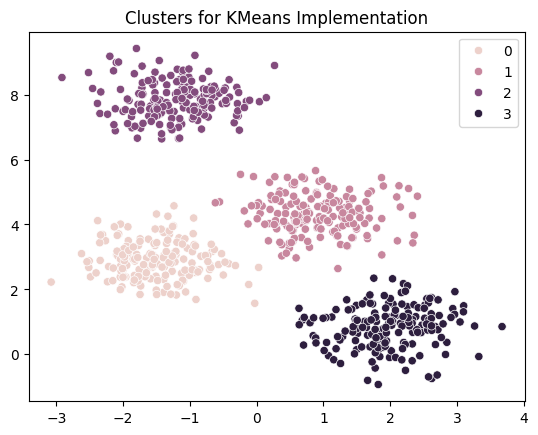

In [5]:
plot_cluster_assignments(X, hyp, 'Clusters for KMeans Implementation')

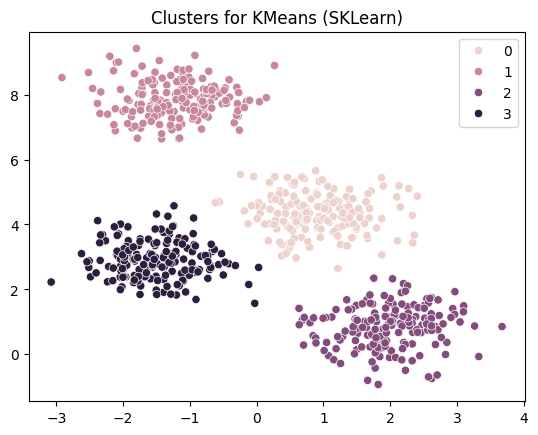

In [6]:
plot_cluster_assignments(X, sk_kmeans.labels_, 'Clusters for KMeans (SKLearn)')

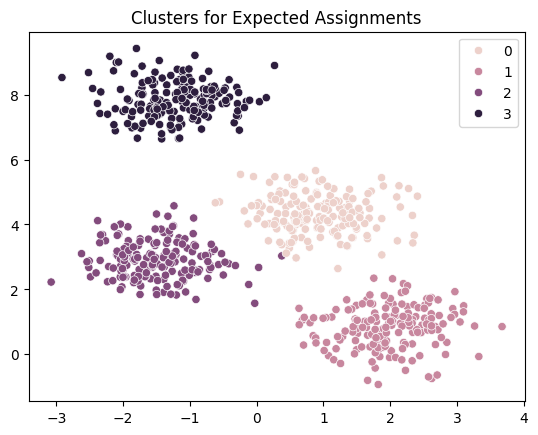

In [7]:
plot_cluster_assignments(X, cluster_assignments, 'Clusters for Expected Assignments')

# Performance Comparison

- cluster_assignments has the expected labels from generating the blobs
- hyp has the labels generated by my implementation
- sk_kmeans.labels_ has the labels generated from sklearn's KMeans

The graphs show very similar clusters but can have different numeric labels, so accuracy can be computed by grouping rows of data by clusters from one set of labels and comparing them to other groupings by a different set of labels. Taking the highest accuracy from these comparisons will be the most similar cluster to another.

### Accuracies from me vs cluster_assignments
- {0: 1.0, 1: 0.9943181818181818, 2: 1.0, 3: 1.0}
- {0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
- Conclusion: 0, 2, 3 from my clusters have an exact match to 0, 1, 3 from the cluster_assignments (not necessarily respective). Cluster 1 from me and cluster 2 from the expected are equivalent and have a 99% overlap.

### Accuracies from me vs KMeans
- {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
- {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
- Conclusion: All clusters have an exact equivalent cluster from my implementation and sklearn's KMeans.

### Accuracies from cluster_assignments vs KMeans
- {0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
- {0: 0.9943181818181818, 1: 1.0, 2: 1.0, 3: 1.0}
- Conclusion: 0, 1, 3 from cluster_assignments have an equivalent match to 1, 2, 3 from sklearn's KMeans (not necessarily respective). Cluster 2 from cluster_assignments and cluster 0 from KMeans are equivalent and have a 99% overlap.


In [8]:
def group_data_by_clusters(data, labels):
    rows_for_clusters = defaultdict(list)
    for i, k in enumerate(labels):
        rows_for_clusters[k].append(data[i])
    return rows_for_clusters

def compute_matches(data_1, data_2):
    # Lengths may not align so check for membership, [True, True] sums to 2 so use those locations to total matches
    matches = np.isin(data_1, data_2)
    full_matches = np.where(2 == np.sum(matches, axis=1))
    return len(full_matches[0]) / len(matches)

def compare_labels(data, labels_1, labels_2):
    # Create a mapping of k to the corresponding rows in cluster k for comparison by row values
    labels_1_data = group_data_by_clusters(data, labels_1)
    labels_2_data = group_data_by_clusters(data, labels_2)
    accuracies = {k: -1 for k in labels_1_data.keys()}
    
    # Cluster labels may not align, so compare all combinations and keep the highest accuracy (most matches)
    for k_1 in labels_1_data.keys():
        for k_2 in labels_2_data.keys():
            accuracies[k_1] = max(accuracies[k_1], compute_matches(labels_1_data[k_1], labels_2_data[k_2]))
    
    return accuracies

In [9]:
# Me vs cluster_assignments

# In a comparison of my implementation and the expected clusters from the make_blobs,
# we see clusters 0, 2, 3 in mine match clusters 0, 1, 3 in the expected with cluster 1-2 having a < 1% difference
pprint(compare_labels(X, hyp, cluster_assignments))
pprint(compare_labels(X, cluster_assignments, hyp))

{0: 1.0, 1: 0.9943181818181818, 2: 1.0, 3: 1.0}
{0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}


In [10]:
# Me vs KMeans

# In a comparison of my implementation and the labels from sklearn's KMeans implementation,
# we see all clusters have a complete equivalent match
pprint(compare_labels(X, hyp, sk_kmeans.labels_))
pprint(compare_labels(X, sk_kmeans.labels_, hyp))

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [11]:
# cluster_assignments vs KMeans

# In a comparison of the expected clusters from the make_blobs and the labels from sklearn's KMeans implementation,
# we see clusters 0, 1, 3 in sklearn's match clusters 1, 2, 3 in the expected with 2 and 0 having a < 1% difference
pprint(compare_labels(X, cluster_assignments, sk_kmeans.labels_))
pprint(compare_labels(X, sk_kmeans.labels_, cluster_assignments))

{0: 1.0, 1: 1.0, 2: 0.9942857142857143, 3: 1.0}
{0: 0.9943181818181818, 1: 1.0, 2: 1.0, 3: 1.0}


# Choose and run clustering algorithms

1. The reason why you chose the clustering algorithm(s)
- DBSCAN is good with geolocation data because it can find clusters of any shape
- It doesn't need a set number of clusters and can handle some noise (which is present with outliers in lat/long)
- Looking at the scatterplot, KMeans would struggle since it's not spheroidal (rectangular strip would be split)

2. Any pre-processing of the data or any hyperparameter settings
- Normalized data in a scaler
- Did not remove outliers since there was no significant effect when pruning data outside a z-score of 3 and DBSCAN handles noise
- min_samples for DBSCAN chosen by doing the (2 * # of features) heuristic
- eps gradually increased and compared

3. Output from the algorithm(s) -- show what clusters were generated
- See graphs at bottom

4. The metrics you used to evaluate the output. What kind of performance did you get from that algorithm? Is that what you expected?

- eps=0.25 has a Silhouette Score of 0.299141919587717
- eps=0.3 has a Silhouette Score of 0.2483204221879443
- eps=0.35 has a Silhouette Score of 0.5611574628181573
- eps=0.4 has a Silhouette Score of 0.551964599928041

- I used Silhouette Score to evaluate the cluster labels. It's a measure of how well the samples are clustered with similar ones. A higher coefficient is denser with more similar intra-cluster samples and inter-cluster separation. 1 is the best, -1 is the worst, and near 0 indicates overlap.
- I gradually increased epsilon and hit a high score at epsilon=0.35 with it dropping slightly at eps=0.40. This seems like a decent score since it's far enough from 0 to show not too much cluster overlap and relatively close to 1. I think this makes sense since increasing epsilon and increasing the cluster size with more dissimilar points would lower the quality of the cluster. 

In [12]:
df = pd.read_csv('Taxi_Trips__2013-2023_.csv')

df

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,52dc9029821e61db30a51838cb3cd711bd0e03cb,275f3f891b8c0ba8f2958873f850d2a03993c99f5f79f6...,02/01/2023 12:15:00 AM,02/01/2023 12:30:00 AM,1140.0,11.20,NaN,NaN,76.0,NaN,...,21.0,49.75,Cash,4053 - 40193 Adwar H. Nikola,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
1,11eeb6710caa0606028c7ba025bfa18c277886e8,6c87f1d023a9d7146ae81b6aa4648bf98cec52cceb9f08...,02/01/2023 12:15:00 AM,02/01/2023 12:15:00 AM,660.0,2.70,NaN,NaN,32.0,7.0,...,0.0,13.00,Credit Card,Taxi Affiliation Services,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843)
2,113aa7bf346c585bb941cda2d5c0015c8a1472f0,bb4e75d3065311c33024a434640731c43fd2cf9e4482eb...,02/01/2023 12:15:00 AM,02/01/2023 12:30:00 AM,480.0,0.00,NaN,NaN,8.0,24.0,...,0.0,9.75,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
3,2503e3944e5c82b89638447ad361638111129375,57c40509cae37a0e5e536a657cdb7f8c6824314bc466a7...,02/01/2023 12:15:00 AM,02/01/2023 12:45:00 AM,1620.0,0.00,1.703198e+10,NaN,76.0,NaN,...,28.0,91.00,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
4,23ddcfba2ad714fe0303909961ea74873be50da2,40720025b84fa778c47d6637db01b1d8f2de2eabafa529...,02/01/2023 12:15:00 AM,02/01/2023 12:15:00 AM,360.0,0.10,NaN,NaN,76.0,NaN,...,4.0,13.75,Cash,Taxi Affiliation Services,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101783,9209df4c3541198fda3173a226f2df619a806022,dee6032433df09fe8d3fd4fa958380308c902dc98f81c3...,02/07/2023 11:45:00 PM,02/07/2023 11:45:00 PM,760.0,2.69,1.703183e+10,1.703132e+10,28.0,32.0,...,0.0,10.90,Mobile,Medallion Leasin,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
101784,f0957a8f6bef37bb2872649fb3c76ad1a179acab,3f6562a2a18861cf21a21101c14cc91dd7c4d72cdce80f...,02/07/2023 11:45:00 PM,02/07/2023 11:45:00 PM,4.0,0.00,NaN,NaN,8.0,8.0,...,0.0,77.40,Credit Card,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
101785,4cb74df671cfccceb9b592f347ef1a94c1540c7a,b31f46efa11263565e3dba91f26ff96b74516e8108ac56...,02/14/2023 10:30:00 AM,02/14/2020 06:00:00 PM,NaN,2.90,NaN,NaN,8.0,24.0,...,0.0,13.50,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
101786,7f24c5101df65952ef318f558b8b071989ff7c17,65057dc10e707a18a32bc4371c5db0b828e90f9caf1068...,04/27/2023 11:15:00 AM,04/21/2019 09:30:00 PM,NaN,15.10,NaN,NaN,76.0,7.0,...,4.0,52.90,Credit Card,Taxi Affiliation Services,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843)


In [13]:
df.info()

'''
Census Tracts not all accounted for because:
The Census Tract is where the trip began. 
For privacy, this Census Tract is not shown for some trips.
This column often will be blank for locations outside Chicago.
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101788 entries, 0 to 101787
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Trip ID                     101788 non-null  object 
 1   Taxi ID                     101779 non-null  object 
 2   Trip Start Timestamp        101788 non-null  object 
 3   Trip End Timestamp          101788 non-null  object 
 4   Trip Seconds                101763 non-null  float64
 5   Trip Miles                  101788 non-null  float64
 6   Pickup Census Tract         35179 non-null   float64
 7   Dropoff Census Tract        35054 non-null   float64
 8   Pickup Community Area       95650 non-null   float64
 9   Dropoff Community Area      92192 non-null   float64
 10  Fare                        101681 non-null  float64
 11  Tips                        101681 non-null  float64
 12  Tolls                       101681 non-null  float64
 13  Extras        

'\nCensus Tracts not all accounted for because:\nThe Census Tract is where the trip began. \nFor privacy, this Census Tract is not shown for some trips.\nThis column often will be blank for locations outside Chicago.\n'

In [14]:
df.describe()

# Trip seconds/miles starts at 0, is non-normal

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,101763.000000,101788.000000,3.517900e+04,3.505400e+04,95650.000000,92192.000000,101681.000000,101681.000000,101681.000000,101681.000000,101681.000000,95657.000000,95657.000000,92489.000000,92489.000000
mean,1102.644891,6.021135,1.703149e+10,1.703140e+10,33.230946,25.300764,20.466054,2.452347,0.014503,1.679117,24.739358,41.898703,-87.689956,41.892116,-87.657546
std,1831.031101,7.572349,3.696445e+05,3.377955e+05,25.309183,20.270499,18.103452,3.918353,0.602782,5.208910,22.641634,0.064621,0.104274,0.059306,0.063430
min,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.913625,41.660136,-87.913625
25%,420.000000,0.870000,1.703108e+10,1.703108e+10,8.000000,8.000000,7.750000,0.000000,0.000000,0.000000,9.500000,41.878866,-87.695013,41.878866,-87.663518
50%,836.000000,2.600000,1.703132e+10,1.703132e+10,32.000000,28.000000,13.500000,0.000000,0.000000,0.000000,16.000000,41.895033,-87.642649,41.892508,-87.633308
75%,1516.000000,10.800000,1.703184e+10,1.703184e+10,50.000000,32.000000,31.000000,3.000000,0.000000,1.000000,33.900000,41.949829,-87.626211,41.922686,-87.625192
max,86003.000000,814.300000,1.703198e+10,1.703198e+10,77.000000,77.000000,999.000000,250.000000,78.000000,182.000000,999.000000,42.015934,-87.534903,42.021224,-87.534903


<Axes: ylabel='Pickup Centroid Latitude'>

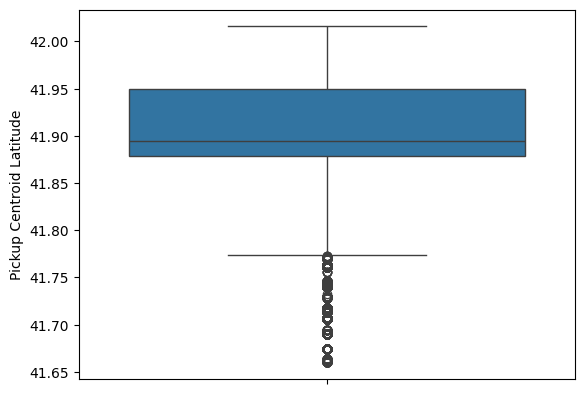

In [15]:
sns.boxplot(data=df['Pickup Centroid Latitude'])

<Axes: ylabel='Pickup Centroid Longitude'>

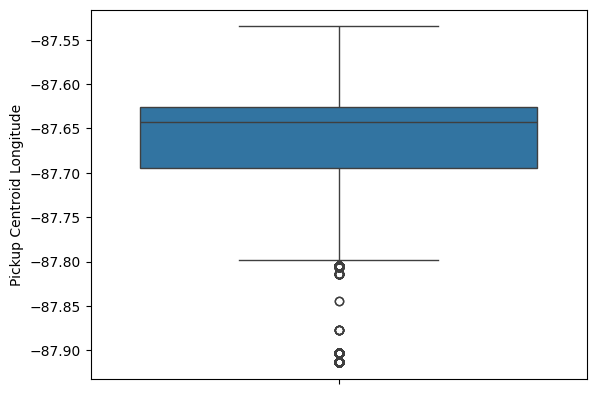

In [16]:
sns.boxplot(data=df['Pickup Centroid Longitude'])

<Axes: xlabel='Pickup Centroid Longitude', ylabel='Pickup Centroid Latitude'>

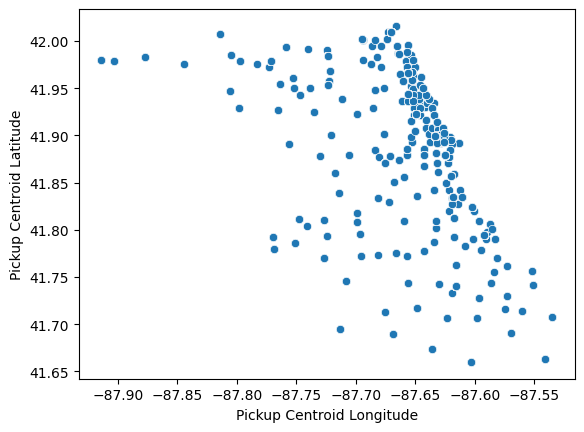

In [17]:
sns.scatterplot(x=df['Pickup Centroid Longitude'], y=df['Pickup Centroid Latitude'])

In [18]:
pickup_df = df[['Pickup Centroid Longitude', 'Pickup Centroid Latitude']]
pickup_df = pickup_df.dropna()

scaler = StandardScaler()
scaler.fit(pickup_df)
normalized_data = scaler.transform(pickup_df)

In [19]:
normalized_data

array([[-2.14503019,  1.26216408],
       [ 0.62109854, -0.30698521],
       [ 0.54326538,  0.01391335],
       ...,
       [ 0.54326538,  0.01391335],
       [ 0.54326538,  0.01391335],
       [-2.14503019,  1.26216408]])

In [20]:
def plot_clusters(eps, min_samples=44):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_data)
    sns.scatterplot(x=normalized_data[:, 0],
                    y=normalized_data[:, 1],
                    hue=clustering.labels_,
                    palette=sns.color_palette("flare", as_cmap=True)
    )
    return clustering.labels_

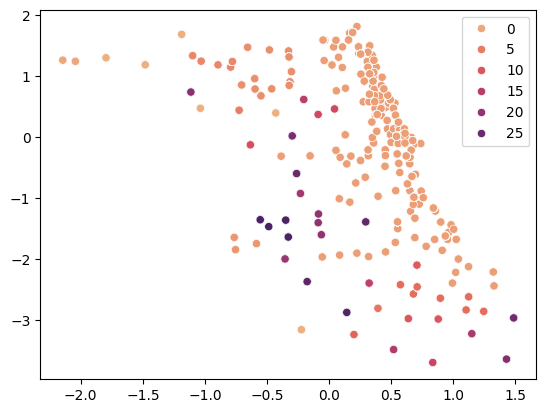

In [21]:
cluster_25 = plot_clusters(.25)

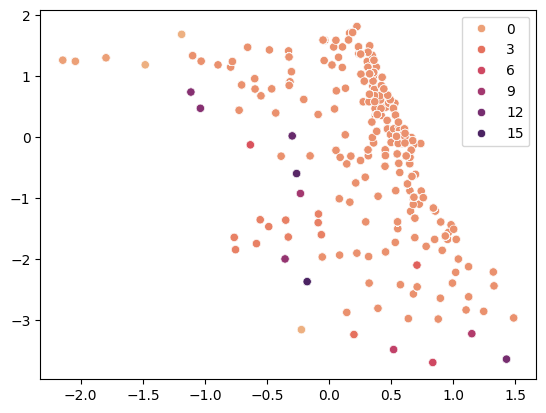

In [22]:
cluster_30 = plot_clusters(.3)

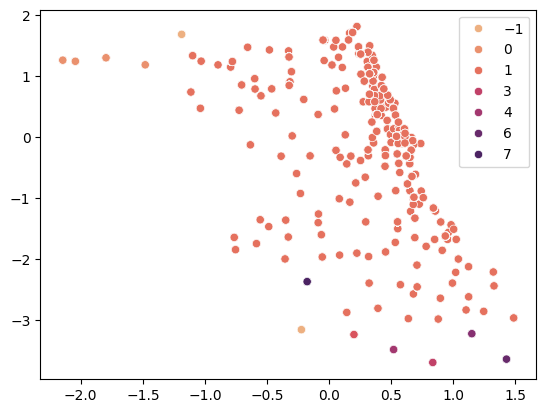

In [23]:
cluster_35 = plot_clusters(.35)

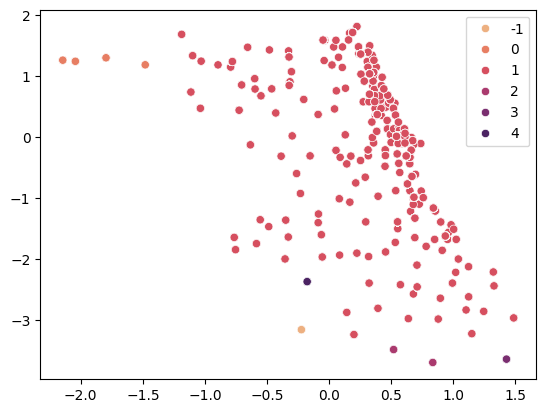

In [24]:
cluster_40 = plot_clusters(.40)

In [27]:
cluster_labels = [(.25, cluster_25), (.30, cluster_30), (.35, cluster_35), (.40, cluster_40)]

for eps, label in cluster_labels:
    print(f'{eps=} has a Silhouette Score of {silhouette_score(normalized_data, label)}')

eps=0.25 has a Silhouette Score of 0.299141919587717
eps=0.3 has a Silhouette Score of 0.2483204221879443
eps=0.35 has a Silhouette Score of 0.5611574628181573
eps=0.4 has a Silhouette Score of 0.551964599928041
